# Xarray interface for neoclassical transport

## `SymbolicEquilibrium`

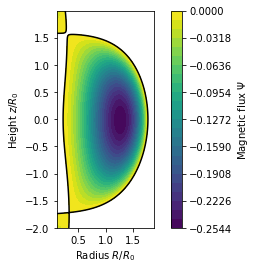

In [1]:
from plasmaboundaries import NSTX_single_null

NSTX_single_null

NSTX_Bt0 = 0.3 * u.T
NSTX_R0 = 0.8 * u.m
NSTX_a0 = 0.64 * u.m
NSTX_I = 1 * u.MA
from plasmapy.plasma.symbolicequilibrium import SymbolicEquilibrium

params = {"aspect_ratio": 1.25, "A": -0.05, "elongation": 2, "triangularity": 0.3}
# TODO this is still not taken in

eq = SymbolicEquilibrium(
    **NSTX_single_null,
    B0=NSTX_Bt0.si.value,  # TODO handle quantity input
    config="single-null",
)
rminmaxstep = (
    0.1,
    1.9,
    0.001,
)  # these definitely, unfortunately, need to be moved into SymbolicEquilibrium
zminmaxstep = (-2, 2, 0.001)
eq.plot(rminmaxstep=rminmaxstep, zminmaxstep=zminmaxstep);

In [2]:
from tqdm.auto import tqdm

In [3]:
import astropy.units as u
import numpy as np
import pandas as pd
import xarray

data_df = pd.read_csv("/home/dominik/IFPILM/Magisterka/HoulbergNSTX.csv", index_col=0)

<AxesSubplot:xlabel='x'>

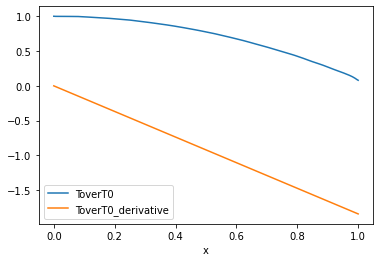

In [4]:
data_df[["x", "ToverT0", "ToverT0_derivative"]].plot(x="x")

<AxesSubplot:xlabel='x'>

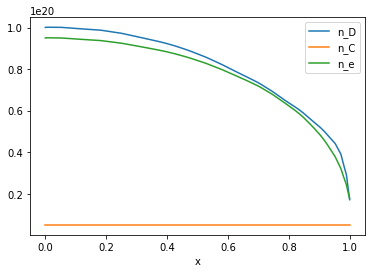

In [5]:
data_df[["x", "n_D", "n_C", "n_e"]].plot(x="x")

<AxesSubplot:xlabel='x'>

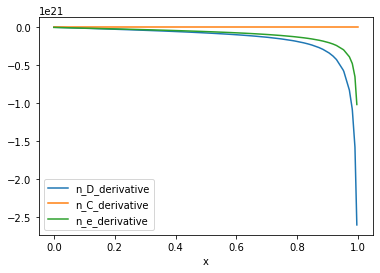

In [6]:
data_df[["x", "n_D_derivative", "n_C_derivative", "n_e_derivative"]].plot(x="x")

In [7]:
T_i = T_e = T_C6 = data_df["ToverT0"] * 0.5 * 1000
dT_i = dT_e = dT_C6 = data_df["ToverT0_derivative"] * 0.5 * 1000
n_e, dn_e = data_df["n_e"], data_df["n_e_derivative"]
n_i, dn_i = data_df["n_D"], data_df["n_D_derivative"]
n_C6, dn_C6 = data_df["n_C"], data_df["n_C_derivative"]

rho = data_df.x.values

## Multiple flux surfaces - radial grid

## `FlowCalculator`

In [8]:
import xarray
attrs = {
        "T unit": u.eV,
        "n unit": u.m ** -3,
        "gradT unit": u.eV / u.m,
        "gradn unit": u.m ** -3 / u.m,
    }

dataset_H1 = xarray.Dataset(
    {
        "T": ("rho", T_i),
        "gradT": ("rho", dT_i),
        "n": ("rho", n_i),
        "gradn": ("rho", dn_i),
        "charges": 1,
    },
    coords={"rho": rho, "particle": "H 1+"},
    attrs=attrs,
)

dataset_C6 = xarray.Dataset(
    {
        "T": ("rho", T_C6),
        "gradT": ("rho", dT_C6),
        "n": ("rho", n_C6),
        "gradn": ("rho", dn_C6),
        "charges": 6,
    },
    coords={"rho": rho, "particle": "C 6+"},
    attrs=attrs,
)
dataset_e = xarray.Dataset(
    {
        "T": ("rho", T_e),
        "gradT": ("rho", dT_e),
        "n": ("rho", n_e),
        "gradn": ("rho", dn_e),
        "charges": -1,
    },
    coords={"rho": rho, "particle": "e-"},
    attrs=attrs,
)

dataset = xarray.concat([
    dataset_H1,
    dataset_C6,
#     dataset_e,
], dim="particle")
# dataset["rho"] = ("rho", rho)
dataset["charge_density"] = "rho", (dataset.charges * dataset.n).sum(dim="particle")
dataset

<xarray.Dataset>
Dimensions:         (particle: 2, rho: 46)
Coordinates:
  * rho             (rho) float64 0.0 0.0056 0.05209 ... 0.9895 0.9957 1.0
  * particle        (particle) <U4 'H 1+' 'C 6+'
Data variables:
    T               (particle, rho) float64 500.0 499.2 498.6 ... 45.67 39.98
    gradT           (particle, rho) float64 -0.0 -5.152 -47.92 ... -916.0 -920.0
    n               (particle, rho) float64 1e+20 1.001e+20 ... 5e+18 5e+18
    gradn           (particle, rho) float64 2.273e+18 1.558e+18 ... 0.0 0.0
    charges         (particle) int64 1 6
    charge_density  (rho) float64 1.3e+20 1.301e+20 ... 5.185e+19 4.715e+19
Attributes:
    T unit:      eV
    n unit:      1 / m3
    gradT unit:  eV / m
    gradn unit:  1 / m4

In [9]:
dataset["psi"] = eq.rho_to_psi(rho)
dataset

<xarray.Dataset>
Dimensions:         (particle: 2, psi: 46, rho: 46)
Coordinates:
  * rho             (rho) float64 0.0 0.0056 0.05209 ... 0.9895 0.9957 1.0
  * particle        (particle) <U4 'H 1+' 'C 6+'
  * psi             (psi) float64 -0.2544 -0.2529 -0.2411 ... -0.001106 0.0
Data variables:
    T               (particle, rho) float64 500.0 499.2 498.6 ... 45.67 39.98
    gradT           (particle, rho) float64 -0.0 -5.152 -47.92 ... -916.0 -920.0
    n               (particle, rho) float64 1e+20 1.001e+20 ... 5e+18 5e+18
    gradn           (particle, rho) float64 2.273e+18 1.558e+18 ... 0.0 0.0
    charges         (particle) int64 1 6
    charge_density  (rho) float64 1.3e+20 1.301e+20 ... 5.185e+19 4.715e+19
Attributes:
    T unit:      eV
    n unit:      1 / m3
    gradT unit:  eV / m
    gradn unit:  1 / m4

In [10]:
# final_dataset = dataset

final_rho = np.linspace(0.61277, 0.61282, 500)
final_rho = np.linspace(0, 1, 50)
final_dataset = dataset.interp({"rho": final_rho})

  0%|          | 0/50 [00:00<?, ?it/s]

/home/dominik/.local/lib/python3.9/site-packages/astropy/units/quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/dominik/.local/lib/python3.9/site-packages/astropy/units/quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/dominik/.local/lib/python3.9/site-packages/astropy/units/quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/dominik/.local/lib/python3.9/site-packages/astropy/units/quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/dominik/.local/lib/python3.9/site-packages/astropy/units/quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__a

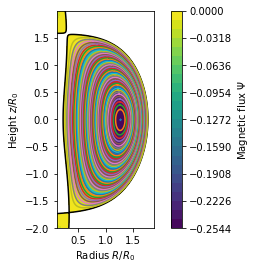

In [12]:
from plasmapy.transport.flows import FlowCalculator
ax = eq.plot(rminmaxstep=rminmaxstep, zminmaxstep=zminmaxstep)
fcs = []
surfaces = []
all_mu = []
datasets = []
for i, (_, surface) in enumerate(tqdm(
        eq.get_multiple_flux_surfaces(
            rho_values=final_dataset.rho, rminmaxstep=rminmaxstep, zminmaxstep=zminmaxstep
        ),
        total=final_dataset.rho.size,
    )):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        fc = FlowCalculator.from_xarray_surface(final_dataset.isel(rho=i), surface)
    try:
        dataset = fc.to_dataset()
    except ValueError:
        continue
    fcs.append(fc)
    all_species = fc.all_species
    all_mu.append(all_species.mu_hat(surface))
    datasets.append(dataset)
    surfaces.append(surface)
    surface.plot(ax)
ax.legend().remove()

In [13]:
results = xarray.concat(datasets, dim="rho")
results["mu_hat"] = ("rho", "particle", "alpha", "beta"), u.Quantity(all_mu).si.value
scaling = (fcs[0].bootstrap_current.unit / NSTX_Bt0).to(u.MA / u.m ** 2)
results = results.assign(
    bootstrap_current_normalized=results.bootstrap_current * scaling
)

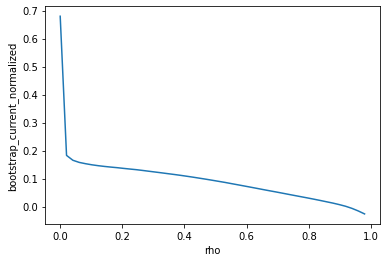

In [14]:
results.bootstrap_current_normalized.plot.line()

In [15]:
# imax = int(np.abs(results.bootstrap_current_normalized).argmax())
# extr = results.isel(psi=imax, rho=imax)

# fs = surfaces[imax][1]

# fc = fcs[imax]

# all_species = fc.all_species

# results["effective_momentum_relaxation_"]

In [16]:
# results.sel(particle="e-").mu_hat.mean(dim=["alpha", "beta"]).plot.line(x="rho")

In [17]:
eq.get_flux_surface

<bound method SymbolicEquilibrium.get_flux_surface of SymbolicEquilibrium(aspect_ratio=0.78, A=-0.05, elongation=2, triangularity=0.35, config='single-null', B0=0.3)>

In [18]:
# rho_to_surface[float(extr.rho)]

# surfaces[imax]

# surfaces[imax]

results.thermal_conductivity

<xarray.DataArray 'thermal_conductivity' (rho: 49, particle: 2)>
array([[            inf,             inf],
       [ 4.30406098e-04,  2.91936443e+00],
       [ 3.98802780e-04,  9.92443343e-01],
       [ 3.98478690e-04,  5.06165002e-01],
       [ 4.06829134e-04,  3.06469301e-01],
       [ 4.18895114e-04,  2.03698372e-01],
       [ 4.32118574e-04,  1.44228127e-01],
       [ 4.45203776e-04,  1.06782867e-01],
       [ 4.57931320e-04,  8.18085963e-02],
       [ 4.69842831e-04,  6.43534222e-02],
       [ 4.81229588e-04,  5.14606794e-02],
       [ 4.91759681e-04,  4.19076206e-02],
       [ 5.01505349e-04,  3.46662286e-02],
       [ 5.10846505e-04,  2.89164849e-02],
       [ 5.19757087e-04,  2.43620590e-02],
       [ 5.27816150e-04,  2.07482269e-02],
       [ 5.35493360e-04,  1.78233521e-02],
       [ 5.42859886e-04,  1.54273149e-02],
       [ 5.49586980e-04,  1.34694537e-02],
       [ 5.56107467e-04,  1.18260276e-02],
...
       [ 6.05244105e-04,  4.07249196e-03],
       [ 6.09292020e-04,  3.72942380e-03],
       [ 6.13624725e-04,  3.43237493e-03],
       [ 6.18476171e-04,  3.17396667e-03],
       [ 6.23244001e-04,  2.94449545e-03],
       [ 6.27909404e-04,  2.74176402e-03],
       [ 6.32543920e-04,  2.54188269e-03],
       [ 6.37305598e-04,  2.35622857e-03],
       [ 6.41909059e-04,  2.18054817e-03],
       [ 6.46466455e-04,  2.00736132e-03],
       [ 6.51759163e-04,  1.85652334e-03],
       [ 6.59333315e-04,  1.72908617e-03],
       [ 6.68344911e-04,  1.61515878e-03],
       [ 6.76509841e-04,  1.45829244e-03],
       [ 6.84094106e-04,  1.29242843e-03],
       [ 6.95074684e-04,  1.12508805e-03],
       [ 7.07916070e-04,  9.38316614e-04],
       [ 7.19688783e-04,  5.94055931e-04],
       [ 7.30856621e-04,  9.23061129e-05],
       [ 7.33878073e-04, -9.26124572e-04]])
Coordinates:
  * particle  (particle) <U4 'C 6+' 'H 1+'
  * rho       (rho) float64 0.0 0.02041 0.04082 0.06122 ... 0.9388 0.9592 0.9796

In [19]:
results.diffusion_coefficient.sel(particle="C 6+")

<xarray.DataArray 'diffusion_coefficient' (rho: 49)>
array([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf])
Coordinates:
    particle  <U4 'C 6+'
  * rho       (rho) float64 0.0 0.02041 0.04082 0.06122 ... 0.9388 0.9592 0.9796

(-10.0, 10.0)

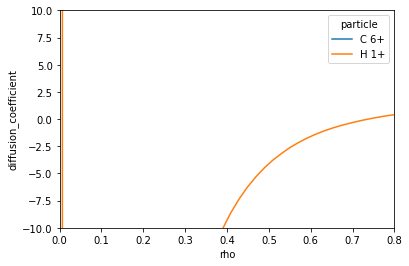

In [20]:
results.diffusion_coefficient.plot.line(x="rho")
plt.xlim(0, 0.8)
plt.ylim(-10, 10)

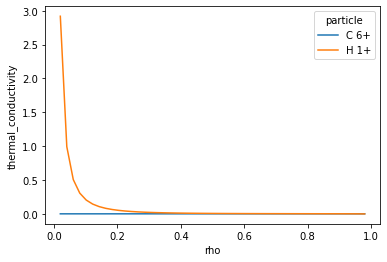

In [21]:
results.thermal_conductivity.plot.line(x="rho")

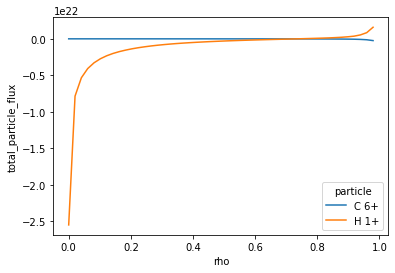

In [22]:
results.total_particle_flux.plot.line(x="rho")

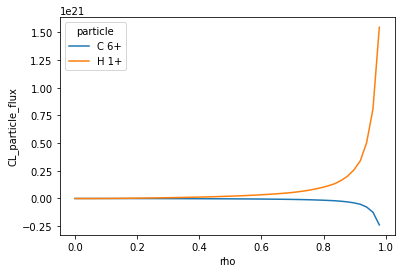

In [23]:
results.CL_particle_flux.plot.line(x="rho")

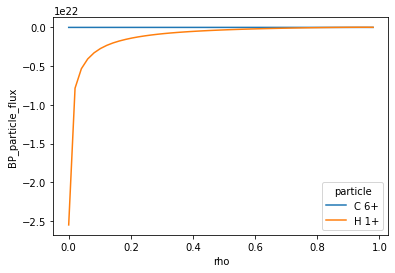

In [24]:
results.BP_particle_flux.plot.line(x="rho")

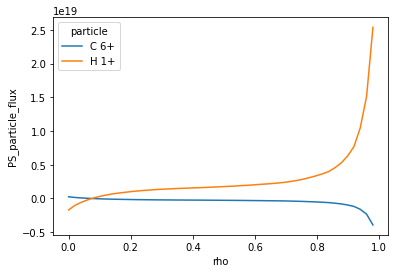

In [25]:
results.PS_particle_flux.plot.line(x="rho")

(0.0, 0.2)

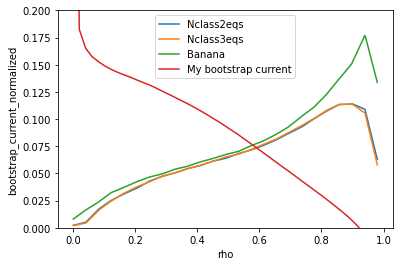

In [26]:
import pandas as pd

df = pd.read_csv("/home/dominik/IFPILM/Magisterka/NSTXplot1.csv")
paper_results = xarray.Dataset.from_dataframe(df).swap_dims({"index": "x"}).drop("index").rename({"x": "rho"})

for values in paper_results:
    paper_results[values].plot.line(x="rho", label=values)
results.bootstrap_current_normalized.plot.line(x="rho", label="My bootstrap current")
plt.legend()
plt.savefig("/home/dominik/screenshot2.png")
plt.ylim(0, 0.2)

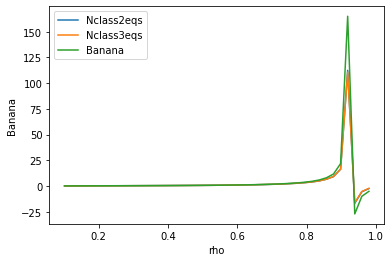

In [27]:
paper_results2 = paper_results.interp({"rho": results.rho})
diff = paper_results2 / results.bootstrap_current_normalized
diff = diff.where(diff.rho > 0.1)
for key in diff:
    diff[key].plot.line(x="rho", label=key)
plt.legend()

TypeError: 'FluxSurface' object is not subscriptable

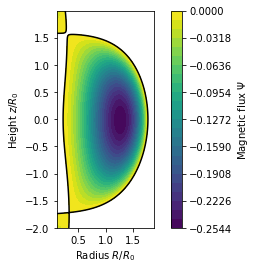

In [28]:
directions = ["poloidal", "toroidal", "parallel", "perpendicular"]
for index, label in enumerate(directions):
    ax = eq.plot(rminmaxstep=rminmaxstep, zminmaxstep=zminmaxstep)
    surfaces[5][1].plot(
        ax, quantity=fcs[-5].local_flow_velocities["H 1+"][index].value, legend=False
    )
    ax.set_title(label)

In [ ]:
for index, label in enumerate(directions):
    ax = eq.plot(rminmaxstep=rminmaxstep, zminmaxstep=zminmaxstep)
    for (psi, surface), fc in zip(surfaces, fcs):
        surface.plot(
            ax,
            quantity=fc.local_flow_velocities["H 1+"][index].value,
            legend=False,
            colorbar=False,
        )
    ax.set_title(label)